# Let's build a simple numpy-based NN to classify MNIST

### Upload the dataset

In [5]:
import h5py
import numpy as np

# load MNIST data
MNIST_data = h5py.File("../../data/MNIST/MNISTdata.hdf5", 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
x_test  = np.float32(MNIST_data['x_test'][:])
y_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)
MNIST_data.close()

# stack together for next step
X = np.vstack((x_train, x_test))
y = np.vstack((y_train, y_test))

# one-hot encoding
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

# number of training set
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]

# shuffle training set
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [17]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((784, 60000), (10, 60000), (784, 10000), (10, 10000))

In [18]:
assert X_train.shape[1] ==  Y_train.shape[1]
assert X_test.shape[1] ==  Y_test.shape[1]

### Weight Initialization
The outputs from a randomly initialized neuron has a variance that grows with the number of inputs. It turns out that we can normalize the variance of each neuron’s output to $1$ by scaling its weight vector by the square root of its number of inputs. 

That is, the recommended heuristic is to initialize each neuron’s weight vector as: 
$w = \frac{\mathbb{N}(n)} {\sqrt(n)}$, where $ n $ is the number of its inputs.

This ensures that all neurons in the network initially have approximately the same output distribution and empirically improves the rate of convergence.

In [55]:
classes = 10
input_n = 784 # (28 x 28)
hidden_n = 64

params = {"W1": np.random.randn(hidden_n, input_n) * np.sqrt(1. / input_n),
          "b1": np.zeros((hidden_n, 1)) * np.sqrt(1. / input_n),
          "W2": np.random.randn(classes, hidden_n) * np.sqrt(1. / hidden_n),
          "b2": np.zeros((classes, 1)) * np.sqrt(1. / hidden_n)}

### Activation Functions
This curve has a finite limit of:

‘0’ as $ x $ approaches $ - \infty $
‘1’ as $ x $ approaches $ + \infty $

In [20]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)

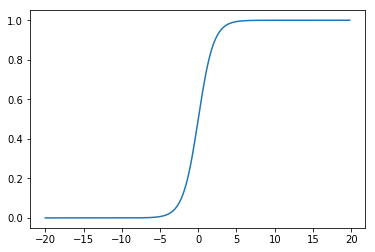

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
x = np.arange(-20., 20., 0.2)
y = sigmoid(x)
plt.plot(x, y)

### Loss Function
What we use in this example is cross-entropy loss.
After averaging over a training set of $ m $ examples.

In [24]:
def loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

### Training step, Forward pass and back propagation

#### Forward pass
The forward pass on a single example $x$ executes the following computation on each layer of Neural Networks:

In [25]:
def feed_forward(X, params):
    """
    feed forward network: 2layer neural net
    inputs:
        params: dictionary contains all the weights and biases
    return:
        cache: a dictionary contains all the fully connected units and activations
    """
    cache = {}

    # Z1 = W1.dot(x) + b1
    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]

    # A1 = sigmoid(Z1)
    cache["A1"] = sigmoid(cache["Z1"])

    # Z2 = W2.dot(A1) + b2
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]

    # A2 = softmax(Z2)
    cache["A2"] = softmax(cache["Z2"])

    return cache

#### Back Propagation
Back propagation is actually a fancy name of chain rules. 

Backpropagation is based around four fundamental equations. Together, those equations give us a way of computing both the error $\delta^l$ and the gradient of the cost function.

An equation for the error in the output layer, $\delta^L$:
\begin{eqnarray} 
  \delta^L_j = \frac{\partial C}{\partial a^L_j} \sigma'(z^L_j).
\tag{BP1}\end{eqnarray}

An equation for the error $\delta^l$ in terms of the error in the next layer, $\delta^{l+1}$:
\begin{eqnarray} 
  \delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l),
\tag{BP2}\end{eqnarray}

An equation for the rate of change of the cost with respect to any bias in the network:
\begin{eqnarray}  \frac{\partial C}{\partial b^l_j} =
  \delta^l_j.
\tag{BP3}\end{eqnarray}

An equation for the rate of change of the cost with respect to any weight in the network:

\begin{eqnarray} 
  \frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j.
\tag{BP4}
\end{eqnarray}

<div class="alert alert-block alert-success">
<b>How backpropagation works:</b> Check out http://neuralnetworksanddeeplearning.com/chap2.html
    <b>Great introduction with intuitive interpretation!</b>
</div>

In [26]:
def back_propagate(X, Y, params, cache, m_batch):
    """
    back propagation

    inputs:
        params: dictionary contains all the weights and biases
        cache: dictionary contains all the fully connected units and activations

    return:
        grads: dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer
    dZ2 = cache["A2"] - Y

    # gradients at last layer (Py2 need 1. to transform to float)
    dW2 = (1. / m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propagate through first layer
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))

    # gradients at first layer (Py2 need 1. to transform to float)
    dW1 = (1. / m_batch) * np.matmul(dZ1, X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

#### Training and Hyper parameter setup
Training process can be simplified as a loop forward pass -> compute loss -> back propagation -> update weights and bias -> forward pass

In [39]:
X_train.shape

(784, 60000)

In [56]:
batch_size = 64
epochs = 100
lr = 0.01
batches = int(X_train.shape[1]/64)
history_loss_train = []

In [57]:
for i in range(epochs):
    # shuffle training set
    permutation = np.random.permutation(X_train.shape[1])
    x_train_shuffled = X_train[:, permutation]
    y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):
        # get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = x_train_shuffled[:, begin:end]
        Y = y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)

        # gradient descent
        params["W1"] = params["W1"] - lr * grads["dW1"] # dW1
        params["b1"] = params["b1"] - lr * grads["db1"] #db1
        params["W2"] = params["W2"] - lr * grads["dW2"] #dW2
        params["b2"] = params["b2"] - lr * grads["db2"] #db2

    # forward pass on training set
    cache = feed_forward(X_train, params)
    train_loss = loss(Y_train, cache["A2"])
    history_loss_train.append(train_loss)
    # forward pass on test set
    cache = feed_forward(X_test, params)
    test_loss = loss(Y_test, cache["A2"])
    print("Epoch {}: training loss = {}, test loss = {}".format(
        i + 1, train_loss, test_loss))

Epoch 1: training loss = 1.623204380193469, test loss = 1.6113645849504843
Epoch 2: training loss = 1.0959083488410803, test loss = 1.0781490074095392
Epoch 3: training loss = 0.8266707391291508, test loss = 0.8079428792725178
Epoch 4: training loss = 0.6824468154255389, test loss = 0.6638398415483551
Epoch 5: training loss = 0.5946645526027842, test loss = 0.5762846175601509
Epoch 6: training loss = 0.5360955586482143, test loss = 0.5180131832685556
Epoch 7: training loss = 0.49410086367875, test loss = 0.47631394996472376
Epoch 8: training loss = 0.46238275985059424, test loss = 0.44460446112276836
Epoch 9: training loss = 0.4381516311528761, test loss = 0.42087858725859145
Epoch 10: training loss = 0.41852581519452364, test loss = 0.4016330446851611
Epoch 11: training loss = 0.4023785909182574, test loss = 0.3858861640289548
Epoch 12: training loss = 0.3891534397888373, test loss = 0.37307861117976704
Epoch 13: training loss = 0.3775934111408165, test loss = 0.36232356529689125
Epoc

### Evaluation

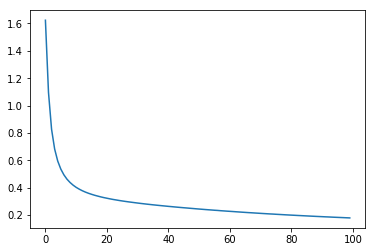

In [58]:
plt.plot(len(history_loss_train)), history_loss_train)

In [67]:
# TODO move to utils.py
def onehot_softmax(out):
    """convert output of softmax to onehot encoding"""
    for 
    one_hot = np.zeros_like(out)
    one_hot[np.argmax(out)] = 1
    return one_hot

In [81]:
out = feed_forward(X_test, params)["A2"]
out_one_hot = np.apply_along_axis(onehot_softmax, axis=1, arr=out.T)

In [82]:
from sklearn.metrics import classification_report

print(classification_report(Y_test.T, out_one_hot))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.95      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.95      0.91      0.93       892
           6       0.95      0.96      0.95       958
           7       0.95      0.94      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.93      0.93      0.93      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000
 samples avg       0.95      0.95      0.95     10000



<div class="alert alert-block alert-info">
<b>Exercise:</b> Writing and training a perceptron with Momentum </div>

### References
- [Towards datascience post](https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815)
- [Neural net from scratch](https://zhenye-na.github.io/2018/09/09/build-neural-network-with-mnist-from-scratch.html)
- [How backpropagation works](http://neuralnetworksanddeeplearning.com/chap2.html)